## Time Series Classification with Conformal Predictors

Este Jupyter Notebook sigue la explicación del genial [blog de Christoph Molnar](https://mindfulmodeler.substack.com/p/week-1-getting-started-with-conformal). Para una exploración de datos exhaustiva y una selección de la métrica, el umbral de decisión, y los hiperparámetros de varios modelos, ver antes el Juppyter Notebook `Exploration_and_Classification.ipnyb` en este mismo repositorio. Para una explicación detallada sobre cuantización de incertidumbre, ver el Jupyter Notebook `UQ.ipnyb`en este mismo repositorio. Aquí nos centraremos en la implementación de el método Conformal Prediction para la clasificación de series temporales.

Usaremos los datos univariate de este estudio 'Multivariate Time Series data of Fatigued and Non-Fatigued Running from Inertial Measurement Units' que se pueden descargar aquí: https://zenodo.org/records/7997851. La autora también escribió un articulo de Medium donde recomienda usar leave-one-subject-out (LOSO), aplica Rocket y compara modelos personalizados con los modelos no personalizados: https://towardsdatascience.com/time-series-classification-for-fatigue-detection-in-runners-a-tutorial-d649e8eb322f. Aquí nos centramos en la cuantificación de incertidumbre y ese estudio queda fuera del alcance de este Jupyter Notebook. 


### 0. Software

In [3]:
import numpy as np
import pandas as pd


# data exploration and preparation  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder

# model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_score, cross_validate

# model performance evaluation
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix

# UQ 
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score


# plotting and displaying in the notebook
import seaborn as sns
from matplotlib import pyplot as plt
#from IPython.display import display
#import emoji

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### 1. Data load and preparation

In [5]:
filename = "data/Accel_mag_all.csv"
df = pd.read_csv(filename, header = None) # 250 ts per person
#df.head() # 6006 rows × 182 columns

In [6]:
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6006 entries, 0 to 6005
Columns: 182 entries, 0 to 181
dtypes: float64(180), int64(1), object(1)
memory usage: 8.3+ MB


In [7]:
# Classes
df[df.columns[1]].value_counts() # dataset is balanced

1
F     3080
NF    2926
Name: count, dtype: int64

#### Time Series Visualization

In [8]:
# example
df.iloc[248:254,1:2]

,1
248,NF
249,NF
250,NF
251,F
252,F
253,F


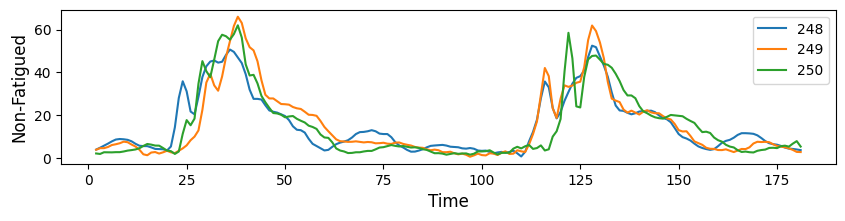

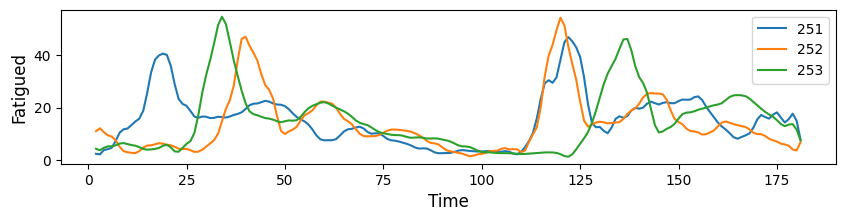

In [11]:
pd1 = df.iloc[248:251,2:].T
pd2 = df.iloc[251:254,2:].T

ax0 = pd1.plot(figsize=(10, 2))
ax0.set_ylabel('Non-Fatigued', fontsize=12)
ax0.set_xlabel('Time', fontsize=12)

ax1 = pd2.plot(figsize=(10, 2))
ax1.set_ylabel('Fatigued', fontsize=12)
ax1.set_xlabel('Time', fontsize=12)

plt.show()

#### Label encoding and scaling

In [12]:
labelencoder = LabelEncoder()
df[df.columns[1]] = labelencoder.fit_transform(df[df.columns[1]])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,181
0,4,0,1.49,4.09,9.27,12.70,12.80,12.00,12.40,13.20,...,9.53,9.30,9.61,9.25,8.07,7.62,8.76,9.61,7.63,3.57
1,4,0,7.35,7.25,7.80,7.94,7.34,6.48,5.87,5.47,...,8.92,7.66,7.76,8.28,8.99,10.20,11.60,11.90,10.70,8.72
2,4,0,9.31,9.06,9.41,9.51,9.23,9.14,9.08,8.45,...,11.40,10.50,9.63,9.29,9.75,10.20,10.10,10.10,10.20,10.00
3,4,0,9.82,10.50,9.86,10.20,10.90,10.60,9.97,9.50,...,11.50,10.60,9.07,7.65,6.83,6.67,6.28,5.09,4.77,7.00
4,4,0,4.68,3.68,4.63,5.01,4.05,3.40,4.00,4.62,...,11.90,10.60,11.10,12.90,14.00,13.60,13.00,12.80,11.50,8.12


In [13]:
standardscaler = StandardScaler()
df_aux = df.iloc[:,2:] # the first col is the person and the 2nd the class
df_scaled = pd.DataFrame(standardscaler.fit_transform(df_aux))
standardscaler = StandardScaler()
df_scaled = pd.DataFrame(standardscaler.fit_transform(df_aux))
df_scaled['Class'] = df[df.columns[1]]
#df_scaled

In [14]:
df_select = df_scaled.copy() # preserve encoded and scaled data

#### Data split and target separation

Note: for UQ we need to separate into 3 sets: the training, the calibration, and the test

In [15]:
# separate train + calibration (= full) and test
df_full_train, df_test = train_test_split(df_select, test_size=0.2, random_state=1)
# now split the full into train and cal, it should be the 20% of the 80%, which is 20/80=1/4=0.25
df_train, df_cal = train_test_split(df_full_train, test_size=0.25, random_state=1) 
len(df_train), len(df_cal), len(df_test)

(3603, 1201, 1202)

In [16]:
# reset index
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_cal = df_cal.reset_index(drop=True)

# define the target
y_train = df_train.Class.values
y_test = df_test.Class.values
y_cal = df_cal.Class.values

# remove the target from the features
del df_train['Class']
del df_test['Class']
del df_cal['Class']

# define the vector of features
X_train = df_train.values
X_test = df_test.values
X_cal = df_cal.values

### 2. Model 

#### Building and training 

In [17]:
if False: # this cell takes about 1min to run in i7 core CPU
    # hyperparameters
    n_estimators = [50, 100, 150]
    max_depth = [5, 10]
    min_samples_leaf = [5, 10]

    RF_param_grid = dict(max_depth = max_depth, min_samples_leaf = min_samples_leaf, n_estimators = n_estimators)

    # model
    model = RandomForestClassifier(max_depth = max_depth, 
                            min_samples_leaf = min_samples_leaf, 
                            n_estimators = n_estimators, 
                            class_weight="balanced",
                            random_state = 1)

    # metric
    metric = make_scorer(accuracy_score)

    # grid
    RF_grid = GridSearchCV(
            estimator = model, 
            param_grid = RF_param_grid,  
            scoring = metric, 
            verbose =1)

    # train the model
    RF_grid_results = RF_grid.fit(X_train, y_train)

    # summarize
    print('Mean acc-score: %.3f' % RF_grid.best_score_)
    print('Standar Deviation:', RF_grid.cv_results_['std_test_score'][RF_grid.best_index_].round(3))
    print('Best Parameters: %s' % RF_grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mean acc-score: 0.858
Standar Deviation: 0.009
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 150}


In [18]:
# let us extract the best random forest 
model = RF_grid_results.best_estimator_

#### Testing

In [19]:
# Predict on test
y_pred = model.predict(X_test)

# Performance metric
acc = accuracy_score(y_test, y_pred)
acc.round(3)

0.865

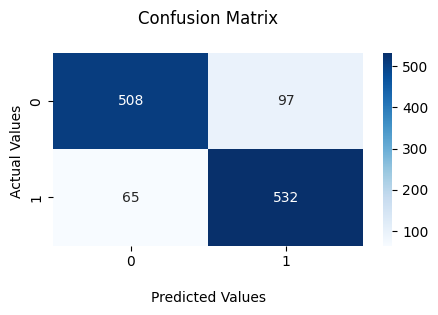

In [21]:
# confusion matrix

cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, fmt='0', annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.rcParams['figure.figsize'] = [5, 2.5]  # re-run this cell to get the correct figure size

plt.show();

La métrica de 'accuracy' divide los aciertos entre el número total de casos. Vemos del conjunto de test con 2723 alubias, (508 + 532) = 1040 time series han sido clasificadas correctamente, dándonos una 'accuracy' (1040/1202)= 0.865, como vimos en una celda anterior. Este valor nos indica que hay un 86.5% de probabilidad de que el resultado del modelo contenga efectivamente a la clase verdadera, no está mal.

#### ¿Pero y si quiero que el modelo prediga la clase verdadera el 95% de las veces? 

Empezamos ya a implementar métodos de UQ que permiten que nuestro modelo exprese la certeza de su predicción. Como veremos estos métodos nos permitirán reducir el número de Falsos Negativos o Positivos y estimar la distribución esperada de la predicción en lugar de un único valor puntual. Pero además nos garantizan la cobertura estadística, es decir, que el modelo prediga la clase verdadera el 95% de las veces. 

Por supuesto que debemos ajustar los hiperparámetros del modelo para optimizar la métrica de 'accuracy'. Sin embargo, no nos queremos centrar en ese trabajo ahora porque queremos demostrar que las métricas, por ejemplo 'accuracy', no indican la certeza que tiene el modelo sobre sus predicciones, sea cual sea el valor de dicha métrica. 

### 3. Uncertainty Quantification

Veamos cómo implementar que el modelo prediga la clase verdadera el 95% de las veces. 

Una idea podría ser aceptar solo aquellas predicciones para las que la 'raw score', sea de la clase que sea, sea mayor que 0.95 y decidir descartar el resto. Aquellas time series cuya puntuación quede por debajo del umbral de la clasificación automática habrán de ser clasificadas de otra manera, por ejemplo, por un ser humano. 


Como dijimos al principio, vamos a seguir la explicación de este genial [blog de Christoph Molnar](https://mindfulmodeler.substack.com/p/week-1-getting-started-with-conformal).

Comúnmente definimos ese umbral con el parámetro 'alpha'. Indica cuánta tolerancia, cuántos errores, es decir, predicciones que caen fuera el conjunto de predicción, estamos dispuestes a aceptar. Para una certeza del 95% de que la predicción del modelo contenga el valor correcto, establecemos que 'alpha' ha de ser igual a 0.05. Es importante notar que 'alpha' no es igual al umbral de decisión 't' que explicamos en la clasificación binaria del Jupyter Notebook `UQ.ipynb` porque aquí vamos a rechazar clasificar aquellas instancias que no alcancen una 'raw score' mayor o igual a 'alpha'. 

Veamos si esta idea inicial es efectiva o no:

In [22]:
df_raw_scores = pd.DataFrame({'Gtruth': y_test, 
                              'Rscor_class0': model.predict_proba(X_test)[:, 0].round(4), 
                              'Rscor_class1': model.predict_proba(X_test)[:, 1].round(4)
                            })
df_raw_scores

,Gtruth,Rscor_class0,Rscor_class1
0,0,0.8513,0.1487
1,1,0.2488,0.7512
2,1,0.1753,0.8247
3,0,0.5973,0.4027
4,0,0.3453,0.6547
...,...,...,...
1197,1,0.0794,0.9206
1198,1,0.3693,0.6307
1199,0,0.8865,0.1135
1200,0,0.6400,0.3600


In [23]:
# choose alpha
alpha = 0.05
num_selected = (model.predict_proba(X_test) >= 1.0 - alpha).sum()
num_discarded = len(df_raw_scores) - num_selected
# how many instances got a raw score in one of their potential classes higher or equal to alpha?
print('The number of time series with a raw score >=', 1.0 - alpha, 'is', num_selected)
print('The number of time series that will be discarded is', num_discarded)

The number of time series with a raw score >= 0.95 is 44
The number of time series that will be discarded is 1158


In [24]:
# select the TS with raw score higher or equal to 1 - alpha
df_alpha_select = df_raw_scores[
                    (df_raw_scores.Rscor_class0 >= 1. - alpha) | 
                    (df_raw_scores.Rscor_class1 >= 1. - alpha)  
                  ]
df_alpha_select.iloc[3:8,:]

,Gtruth,Rscor_class0,Rscor_class1
114,0,0.9534,0.0466
117,0,0.9753,0.0247
170,1,0.0465,0.9535
171,0,0.9934,0.0066
202,0,0.9870,0.0130


In [25]:
# convert raw scores in class prediction
def select_class_alpha(Rscor_class0, Rscor_class1):
    if Rscor_class0 >= 1. - alpha:
        return 0
    elif Rscor_class1 >= 1. - alpha:
        return 1
    else:
        return np.nan

df_alpha_select['AlphaPred'] = df_alpha_select.apply(lambda x: select_class_alpha(
                                    x.Rscor_class0, x.Rscor_class1), axis=1)
#df_alpha_select.reset_index(drop = True)#.head()

In [26]:
# percentage of well classified ones
acc_select = accuracy_score(np.array(df_alpha_select.Gtruth), np.array(df_alpha_select.AlphaPred))

print('With alpha =', 1. - alpha,'we got an accuracy of', acc_select.round(3),'and we have discarded', 
      num_discarded,'out of', len(X_test))

With alpha = 0.95 we got an accuracy of 1.0 and we have discarded 1158 out of 1202


Hemos seleccionado las TS con 'raw scores' por encima o iguales a 0.95 pero sin tener en cuenta su clase real, es decir, no hemos comprobado la 'raw score' de la 'ground truth'. Vamos a probar ahora otra idea, que va a terner en cuenta los valores verdaderos y se va a centrar en encontrar el umbral para que se cumpla la garantía de cobertura. Para ello nos va a proveer de un intervalo de predicción alredor del resultado y este intervalo sí va a contener a la clase verdadera con un 95% de probabilidad.

#### Conformal Prediction

La ['Conformal Prediction'](https://en.wikipedia.org/wiki/Conformal_prediction) es un método para cuantizar la certidumbre de los resultados de un modelo. Recibe su nombre de la denominama medida de no conformidad, o 'nonconformity measure' que cuantiza cuán diferente es la  predicción dentro del conjunto de predicciones que obtuvimos al predecir el conjunto de entrenamiento. Una alta 'nonconformity' indica que el nuevo dato es raro, como la foto de le pájare en el ejemplo de clasificación de perres y gates de la Introducción del Jupyter Notebook `UQ.ipynb` de este mismo repositorio. Recomendamos encarecidamente leer la introducción teórica a los Conformal Predictors en la sección homóloga  aesta en ese Jupyter Notebook.

Las personas que aplicamos Conformal Predictions nos llamamos 'nonconformists'.


<font size="5">😎<font/>

#### Optional: How to manually calculate the nonconformity measure with the Hing Loss (aka "label method" in MAPIE package)

In [32]:
# predict the calibration set
y_pred_cal = model.predict_proba(X_cal)

# take the raw scores of the true class
# try it:
# a = np.arange(2)
# b = y_cal[0:2] <-- clase verdadera
# c = y_pred_cal[0:2,:] <-- clase predicha
# c[a,b]  <-- va por c y si b es "3" pues coje de c el valor en la posicion 3
rscor_true_class = y_pred_cal[np.arange(len(y_cal)),y_cal] 

# define a non conformity measure here we chose the HINGE LOSS probability of not predicting the true class
S = 1. - rscor_true_class 

# find the (1 - alpha)-th quantile of S 
# given a vector V, the q-th quantile of V is the value q of the 
# way from the minimum to the maximum in a sorted copy of V
small_sample = (len(y_cal)+1)/len(y_cal) # finite sample correction, i.e. (n+1)/n
qhat = np.quantile(S, (1. - alpha)*small_sample) 
print('The', (1. - alpha), '-th order quantile is S_q =', qhat.round(4))  # in MAPIE qhat or S_q is called "q"

The 0.95 -th order quantile is S_q = 0.5877


![MAPIE_uq](./images/MAPIE_classification.png "MAPIE_uq")

[Fuente de la imagen: _"MAPIE docs"_](https://mapie.readthedocs.io/en/latest/theoretical_description_classification.html)

#### With MAPIE

In [33]:
# fit the CP with the calibration set
cp = MapieClassifier(estimator = model, cv="prefit",  method="score") # prefit bcs we use the previous gnb
cp.fit(X_cal, y_cal)

MapieClassifier(cv='prefit',
                estimator=RandomForestClassifier(class_weight='balanced',
                                                 max_depth=10,
                                                 min_samples_leaf=5,
                                                 n_estimators=150,
                                                 random_state=1),
                method='score')

In [34]:
# apply to the new TS
n = 1

y_pred, y_set = cp.predict(X_test[n].reshape(1, -1), alpha=alpha) # y_pred is equal to the previous y_pred from model

print('Predicted class', y_pred)
print('True class', y_test[n])
print('Prediction set:')
print(y_set)

Predicted class [1]
True class 1
Prediction set:
[[[False]
  [ True]]]


Vamos a comprobar la cobertura de los conjuntos de predicción, es decir, vamos a ver cuántas veces recogieron de verdad la clase correcta. 

In [37]:
# prediction sets for all the instance
y_pred, y_set = cp.predict(X_test, alpha=alpha) # same y_pred as the one we got with model

# metric to get the accuracy = coverage
cp_acc = classification_coverage_score(y_test, y_set[:, :, 0])

print('CP approach: with alpha =', 1. - alpha,'we got an accuracy of', round(cp_acc, 2),'and we have discarded 0 instances')

CP approach: with alpha = 0.95 we got an accuracy of 0.95 and we have discarded 0 instances


In [38]:
# percentage of well classifies ones from the naive approach we explained at the beginning of the section
acc_select = accuracy_score(np.array(df_alpha_select.Gtruth), np.array(df_alpha_select.AlphaPred))
print('Naive approach: with alpha =', 1. - alpha,'we got an accuracy of', acc_select.round(3),'and we have discarded', 
      num_discarded, 'instances')

Naive approach: with alpha = 0.95 we got an accuracy of 1.0 and we have discarded 1158 instances


Vemos que ahora ya obtenemos de sobra la cobertura desdeada sin desaprovechar ninguna instancia.

<font size="5"> 🥳 </font>

Con el método de UQ de Conformal Predicion hemos visto que podemos identificar aquellas clasificaciones inciertas y dar un conjunto de predicción que nos asegura contener la clase correcta un (1-alpha)% de las veces. 

Vemos que es un método fácil de implementar y rápido, y nos proporciona certidumbre en las predicciones. Aquí lo hemos aplicado a una tarea de clasificación pero los CP pueden aplicarse a cualquier tipo de tarea, no es un método paramétrico y es agnóstico del modelo de predicción.



<font size="5">🎈♫♫🎈🎈♫🎈♫♫♫♫🎈🎈 ♫♫♫ 🎈🎈</font>